# Using Fenics to define a WorkPiece

[Fenics](https://fenicsproject.org/) provides an easy and efficient way to numerically solve partial differential equations with finite element discretizations.   MUQ's python interface can create a WorkPiece that can evaluate a Fenics problem.  The WorkPiece can then be used with other MUQ WorkPieces to define more complicated models, Bayesian posterior densities, etc...

### Overview
This example illustrates basic usage of the Fenics Workpiece.  In particular, this example shows
1. How to define the Poisson equation as a Fenics linear variational problem
2. How to pass the linear variational problem to MUQ to create a WorkPiece
3. How to evaluate solve the Poisson equation by evaluating the WorkPiece

### Installation
This notebook requires MUQ to be compiled with Fenics support.   [These directions on the MUQ Wiki](https://muqmuq.atlassian.net/wiki/spaces/MUN/pages/39124994/How+to+set+up+MUQ+with+Fenics+support) provide one of the easiest way to accomplish this with Docker containers. 

## Part 1: Imports

In [1]:
%matplotlib inline

import dolfin as dl
import pymuqModeling as mm

import numpy as np
import matplotlib.pyplot as plt

dl.parameters['linear_algebra_backend'] = 'Eigen'

## Part 2: Fenics problem definition

In [2]:
Nx = 32
Ny = 32
mesh = dl.UnitSquareMesh(Nx, Ny)
V = dl.FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS

# Define boundary condition
u0 = dl.Constant(0.0)
bc = dl.DirichletBC(V, u0, boundary)

# Define variational problem
logK = dl.interpolate(dl.Expression("0.0",degree=2), V)
u = dl.TrialFunction(V)
v = dl.TestFunction(V)

f = dl.interpolate(dl.Expression("0.0",degree=2), V)

g = dl.Expression("sin(5*x[0])", degree=2)

a = dl.exp(logK)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx

L = f*v*dl.dx + g*v*dl.ds

In [3]:
u = dl.Function(V)

prob = dl.LinearVariationalProblem(a, L, u, bc)

## Part 3: Wrap the variational problem in a MUQ WorkPiece

In [4]:
piece = mm.FenicsPiece(prob, u, [logK])
kVec = logK.vector()

## Part 4: Evaluate the WorkPiece

In [5]:
outputList = piece.Evaluate([np.array(kVec)])
pred = outputList[0]

## Part 5: Add noise to the solution

In [6]:
pred += 1e-2*np.random.randn(pred.shape[0])

u2 = dl.Function(V)
u2.vector().set_local(pred)

array([-0.00562158, -0.01049209,  0.04118916, ..., -0.0374753 ,
        0.00465577, -0.00806799])

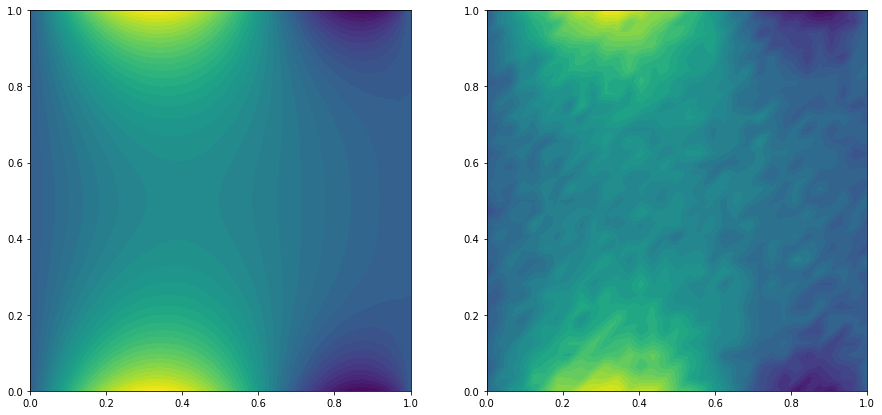

In [7]:

plt.figure(figsize=(15,10))

plt.subplot(121)
dl.plot(u)

plt.subplot(122)
dl.plot(u2)
